In [1]:
import nbimporter
from nbimporter import NotebookLoader

path = 'C:\\Users\\parva\\Desktop\\mldlnew\\training_MNIST.ipynb'
loader = NotebookLoader(path)
loader.load_module('training_MNIST')
from training_MNIST import *


In [2]:
# Importing all the libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import os
import struct
import numpy as np
import training_MNIST

In [3]:
# Function to load MNIST data from ubyte files
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 28, 28)
    return images, labels

# Load and preprocess the dataset
path = 'C:\\Users\\parva\\Desktop\\mldlnew\\MNIST'
x_train, y_train = load_mnist(path, kind='train')
x_test, y_test = load_mnist(path, kind='t10k')
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
# Build the DNN model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),  # Increased to 256 neurons
    BatchNormalization(),  # Add batch normalization
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\parva\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on the training data
_, training_accuracy = model.evaluate(x_train, y_train)
print(f'Training Accuracy: {training_accuracy}')

# Evaluate the model on the testing data
_, testing_accuracy = model.evaluate(x_test, y_test)
print(f'Testing Accuracy: {testing_accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9020 - loss: 0.3263 - val_accuracy: 0.9589 - val_loss: 0.1284
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9695 - loss: 0.1031 - val_accuracy: 0.9722 - val_loss: 0.0949
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9766 - loss: 0.0762 - val_accuracy: 0.9757 - val_loss: 0.0763
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9793 - loss: 0.0635 - val_accuracy: 0.9742 - val_loss: 0.0809
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9840 - loss: 0.0510 - val_accuracy: 0.9771 - val_loss: 0.0781
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9903 - loss: 0.0298
Training Accuracy: 0.9901999831199646
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9731 - loss: 0.0951
Testing Accuracy: 0.9771000146865845


In [6]:
#-------------------- PGD Attack -------------------
epsilon = 0.06
alpha = 0.02
num_iter = 200

x_test_pgd = pgd_attack(model, x_test, y_test, epsilon, alpha, num_iter)
_, adv_testing_accuracy = model.evaluate(x_test_pgd, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(model.predict(x_test_pgd), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the PGD attack on the subset:", success_rate_subset)

#-------------------- BIM Attack  -------------------

epsilon = 0.06  
epsilon_iter = 0.05  
num_steps = 20  
x_test_adv = bim_attack(model, x_test, y_test, epsilon, epsilon_iter, num_steps)

_, adv_testing_accuracy = model.evaluate(x_test_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(model.predict(x_test_adv), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the FGSM attack on the subset:", success_rate_subset)

#--------------------- C & W Attack -------------------

target_class = 0  # Target class for misclassification
x_adv = cw_attack(model, x_test, y_test, target_class)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = model.evaluate(x_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(model.predict(x_adv), axis=1)
success_rate_subset = np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))
print("Success rate of the FGSM attack on the subset:", success_rate_subset)

#--------------------- JSMA Attack  -------------------

# JSMA attack parameters
epsilon_jsma = 0.5
num_iterations_jsma = 150
theta_jsma = 0.5

# Generate adversarial examples for the full test data
x_adv_jsma_all = jsma_attack(model, x_test, y_test, epsilon=epsilon_jsma, num_iterations=num_iterations_jsma, theta=theta_jsma)

# Evaluate the model on the adversarial examples
adv_loss_jsma, adv_acc_jsma = model.evaluate(x_adv_jsma_all, y_test)

# Calculate the success rate of the attack
success_rate_jsma = (1 - adv_acc_jsma) * 100  # Misclassification rate
print("JSMA Attack - Success Rate:", success_rate_jsma, "%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2879 - loss: 3.3392
Adversarial Testing Accuracy: 0.3422999978065491
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
Success rate of the PGD attack on the subset: 0.6577
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3050 - loss: 3.1257
Adversarial Testing Accuracy: 0.35830000042915344
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
Success rate of the FGSM attack on the subset: 0.6417
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3358 - loss: 4.9707
Adversarial Testing Accuracy: 0.382999986410141
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Success rate of the FGSM attack on the subset: 0.617
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3428 - loss: 47.3369
JSMA Attack - Success Rate: 60.85000038146973 %


In [7]:
# Train the first model with high temperature
T = 10
model_with_temp = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(10, activation=lambda x: tf.nn.softmax(x / T))
])
model_with_temp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_with_temp.fit(x_train, y_train, epochs=5, batch_size=32)

# Use the first model to label the training set with soft labels
soft_labels = model_with_temp.predict(x_train)

# Train a second model (distilled model) with soft labels
distilled_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
distilled_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
distilled_model.fit(x_train, soft_labels, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8314 - loss: 0.6660
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9420 - loss: 0.2043
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9610 - loss: 0.1398
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9713 - loss: 0.1023
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9770 - loss: 0.0825
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9077 - loss: 0.3560
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9854 - loss: 0.1215
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9898 - loss: 0.1154
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9904 - loss: 0.1151
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9916 - loss: 0.1135


In [8]:
#-------------------- PGD Attack -------------------
epsilon = 0.06
alpha = 0.02
num_iter = 200

x_test_pgd = pgd_attack(distilled_model, x_test, y_test, epsilon, alpha, num_iter)
_, adv_testing_accuracy = distilled_model.evaluate(x_test_pgd, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(distilled_model.predict(x_test_pgd), axis=1)
success_rate_PGD = (np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1)))*100
print("Success rate of the PGD attack on the subset:", success_rate_PGD)

#-------------------- BIM Attack  -------------------

epsilon = 0.06  
epsilon_iter = 0.05  
num_steps = 20  
x_test_adv = bim_attack(distilled_model, x_test, y_test, epsilon, epsilon_iter, num_steps)

_, adv_testing_accuracy = distilled_model.evaluate(x_test_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

y_pred_adv_subset = np.argmax(distilled_model.predict(x_test_adv), axis=1)
success_rate_BIM = (np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1))) *100
print("Success rate of the FGSM attack on the subset:", success_rate_BIM)

#--------------------- C & W Attack -------------------

target_class = 0  # Target class for misclassification
x_adv = cw_attack(distilled_model, x_test, y_test, target_class)

# Evaluate the adversarially attacked model
_, adv_testing_accuracy = distilled_model.evaluate(x_adv, y_test)
print(f'Adversarial Testing Accuracy: {adv_testing_accuracy}')

# Evaluate the success rate of the attack on the subset
y_pred_adv_subset = np.argmax(distilled_model.predict(x_adv), axis=1)
success_rate_CW = (np.mean(y_pred_adv_subset != np.argmax(y_test, axis=1)))*100
print("Success rate of the FGSM attack on the subset:", success_rate_CW)

#--------------------- JSMA Attack  -------------------

# JSMA attack parameters
epsilon_jsma = 0.5
num_iterations_jsma = 150
theta_jsma = 0.5

# Generate adversarial examples for the full test data
x_adv_jsma_all = jsma_attack(model, x_test, y_test, epsilon=epsilon_jsma, num_iterations=num_iterations_jsma, theta=theta_jsma)

# Evaluate the model on the adversarial examples
adv_loss_jsma, adv_acc_jsma = model.evaluate(x_adv_jsma_all, y_test)

# Calculate the success rate of the attack
success_rate_jsma = (1 - adv_acc_jsma) * 100  # Misclassification rate
print("JSMA Attack - Success Rate:", success_rate_jsma, "%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4261 - loss: 1.7407
Adversarial Testing Accuracy: 0.47920000553131104
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
Success rate of the PGD attack on the subset: 52.080000000000005
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4262 - loss: 1.7336
Adversarial Testing Accuracy: 0.47999998927116394
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Success rate of the FGSM attack on the subset: 52.0
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1332 - loss: 4.0775
Adversarial Testing Accuracy: 0.16990000009536743
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Success rate of the FGSM attack on the subset: 83.00999999999999
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3428 - loss: 47.3369
JSMA Attack - Success Rate: 60.85000038146973 %


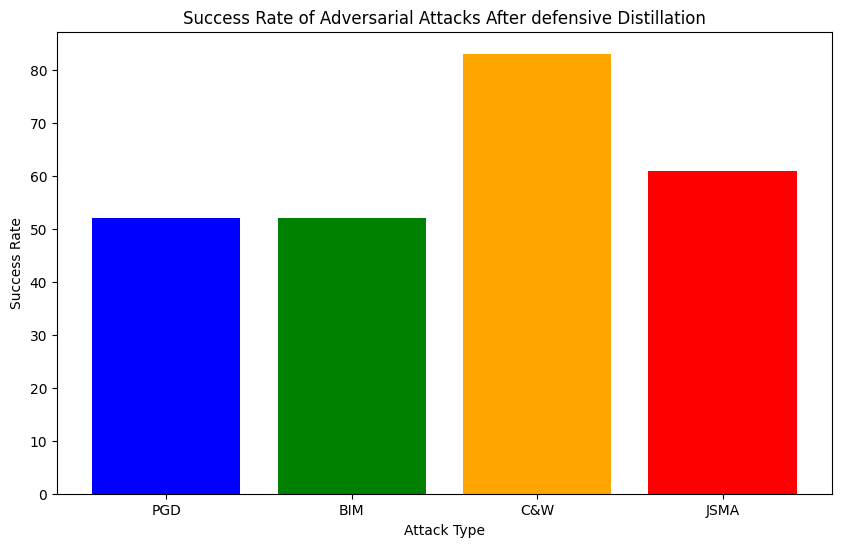

In [10]:
import matplotlib.pyplot as plt

# Success rates of the attacks
success_rates = [success_rate_PGD, success_rate_BIM, success_rate_CW, success_rate_jsma]

# Attack labels
attacks = ['PGD', 'BIM', 'C&W', 'JSMA']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(attacks, success_rates, color=['blue', 'green', 'orange', 'red'])

# Adding labels and title
plt.xlabel('Attack Type')
plt.ylabel('Success Rate')
plt.title('Success Rate of Adversarial Attacks After defensive Distillation')

# Displaying the plot
plt.show()